# Amazon Q&A - Sentiment Analysis & Collaborative Filtering
## Home and Kitchen Category

**Tasks:**
1. Sentiment Analysis on Answers (VADER)
2. Readability Scores
3. Lexical Features (punctuation - word count done in EDA)
4. User-Item Matrix Construction
5. Item-Item & User-User Collaborative Filtering
6. Evaluation with RMSE/MAE

---


## 1. Setup and Data Loading


In [2]:
# Install required packages if not available
import subprocess
import sys

def install_package(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package, "-q"])

# Install VADER sentiment analyzer
try:
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
except ImportError:
    install_package("vaderSentiment")
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Install textstat for readability scores
try:
    import textstat
except ImportError:
    install_package("textstat")
    import textstat

In [3]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import string
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse
from scipy.sparse import csr_matrix

warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

In [4]:
# Load processed data from EDA
DATA_PATH = '../data/processed/processed_home_kitchen_qa.pkl'

print(f"Loading data from: {DATA_PATH}")
df = pd.read_pickle(DATA_PATH)

print(f"✓ Data loaded successfully!")
print(f"Shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")


Loading data from: ../data/processed/processed_home_kitchen_qa.pkl
✓ Data loaded successfully!
Shape: (184439, 16)

Columns: ['questionType', 'asin', 'answerTime', 'unixTime', 'question', 'answer', 'answerType', 'question_char_len', 'answer_char_len', 'question_word_count', 'answer_word_count', 'datetime', 'year', 'month', 'day_of_week', 'year_month']


---
## 2. Sentiment Analysis on Answers (VADER)

VADER (Valence Aware Dictionary and sEntiment Reasoner) is specifically tuned for social media and product reviews.


In [5]:
# Initialize VADER Sentiment Analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to get sentiment scores
def get_sentiment_scores(text):
    """Get VADER sentiment scores for text."""
    if pd.isna(text) or text == '':
        return {'neg': 0, 'neu': 0, 'pos': 0, 'compound': 0}
    return analyzer.polarity_scores(str(text))

# Test VADER on sample texts
test_texts = [
    "This product is amazing! I love it!",
    "Terrible quality, waste of money.",
    "It's okay, nothing special.",
    "Yes, it works fine.",
    "No, I don't recommend this."
]

print("VADER Sentiment Analysis Examples:")
print("=" * 70)
for text in test_texts:
    scores = get_sentiment_scores(text)
    print(f"\nText: {text}")
    print(f"Scores: neg={scores['neg']:.3f}, neu={scores['neu']:.3f}, pos={scores['pos']:.3f}, compound={scores['compound']:.3f}")


VADER Sentiment Analysis Examples:

Text: This product is amazing! I love it!
Scores: neg=0.000, neu=0.368, pos=0.632, compound=0.862

Text: Terrible quality, waste of money.
Scores: neg=0.663, neu=0.337, pos=0.000, compound=-0.710

Text: It's okay, nothing special.
Scores: neg=0.367, neu=0.325, pos=0.309, compound=-0.092

Text: Yes, it works fine.
Scores: neg=0.000, neu=0.308, pos=0.692, compound=0.542

Text: No, I don't recommend this.
Scores: neg=0.345, neu=0.655, pos=0.000, compound=-0.276


In [6]:

# Get sentiment scores for each answer
sentiment_scores = df['answer'].apply(get_sentiment_scores)

# Extract individual components
df['sentiment_neg'] = sentiment_scores.apply(lambda x: x['neg'])
df['sentiment_neu'] = sentiment_scores.apply(lambda x: x['neu'])
df['sentiment_pos'] = sentiment_scores.apply(lambda x: x['pos'])
df['sentiment_compound'] = sentiment_scores.apply(lambda x: x['compound'])

# Classify sentiment based on compound score
def classify_sentiment(compound):
    if compound >= 0.05:
        return 'Positive'
    elif compound <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['sentiment_label'] = df['sentiment_compound'].apply(classify_sentiment)


In [7]:
# Sentiment Statistics
print("\nSENTIMENT ANALYSIS RESULTS")
print("=" * 60)

print("\nCompound Score Statistics:")
print(df['sentiment_compound'].describe())

print("\n\nSentiment Distribution:")
sentiment_dist = df['sentiment_label'].value_counts()
sentiment_pct = df['sentiment_label'].value_counts(normalize=True) * 100

for label in ['Positive', 'Neutral', 'Negative']:
    if label in sentiment_dist.index:
        print(f"  {label:10}: {sentiment_dist[label]:>8,} ({sentiment_pct[label]:.1f}%)")



SENTIMENT ANALYSIS RESULTS

Compound Score Statistics:
count    184439.000000
mean          0.289992
std           0.413012
min          -0.993200
25%           0.000000
50%           0.308900
75%           0.654200
max           0.998900
Name: sentiment_compound, dtype: float64


Sentiment Distribution:
  Positive  :  107,283 (58.2%)
  Neutral   :   51,119 (27.7%)
  Negative  :   26,037 (14.1%)


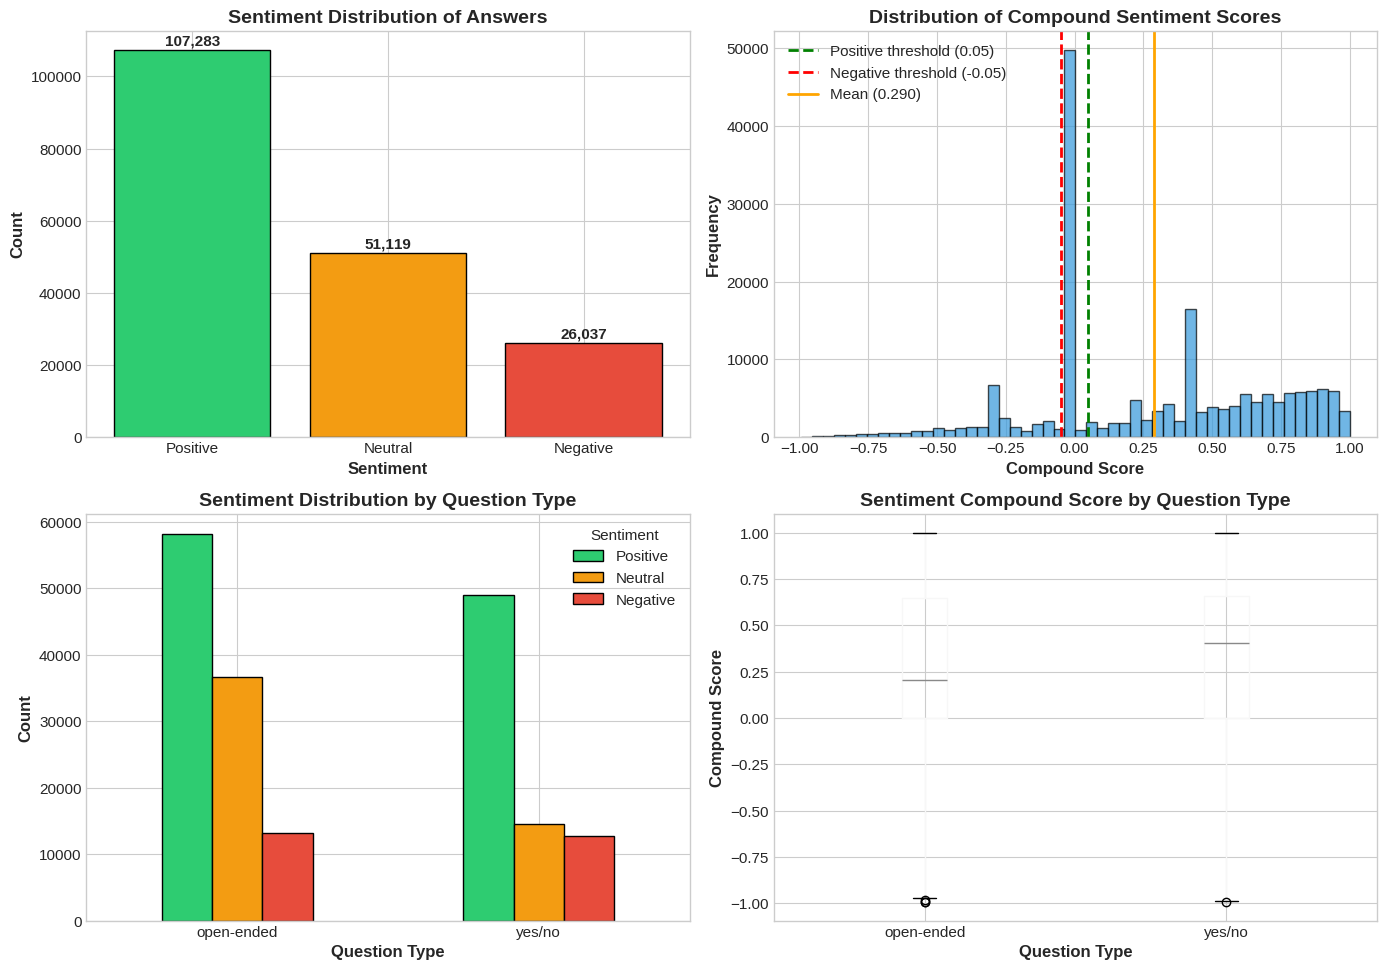

In [8]:
# Visualize Sentiment Distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Sentiment Label Distribution
ax1 = axes[0, 0]
colors_sent = {'Positive': '#2ecc71', 'Neutral': '#f39c12', 'Negative': '#e74c3c'}
sentiment_order = ['Positive', 'Neutral', 'Negative']
sentiment_counts = df['sentiment_label'].value_counts().reindex(sentiment_order)
bars = ax1.bar(sentiment_counts.index, sentiment_counts.values, 
               color=[colors_sent[x] for x in sentiment_counts.index], edgecolor='black')
ax1.set_xlabel('Sentiment', fontsize=12, fontweight='bold')
ax1.set_ylabel('Count', fontsize=12, fontweight='bold')
ax1.set_title('Sentiment Distribution of Answers', fontsize=14, fontweight='bold')
for bar, count in zip(bars, sentiment_counts.values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 500, 
             f'{count:,}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# 2. Compound Score Distribution
ax2 = axes[0, 1]
ax2.hist(df['sentiment_compound'], bins=50, color='#3498db', edgecolor='black', alpha=0.7)
ax2.axvline(x=0.05, color='green', linestyle='--', linewidth=2, label='Positive threshold (0.05)')
ax2.axvline(x=-0.05, color='red', linestyle='--', linewidth=2, label='Negative threshold (-0.05)')
ax2.axvline(x=df['sentiment_compound'].mean(), color='orange', linestyle='-', linewidth=2, 
            label=f'Mean ({df["sentiment_compound"].mean():.3f})')
ax2.set_xlabel('Compound Score', fontsize=12, fontweight='bold')
ax2.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax2.set_title('Distribution of Compound Sentiment Scores', fontsize=14, fontweight='bold')
ax2.legend()

# 3. Sentiment by Question Type
ax3 = axes[1, 0]
sentiment_by_type = df.groupby(['questionType', 'sentiment_label']).size().unstack(fill_value=0)
sentiment_by_type = sentiment_by_type[['Positive', 'Neutral', 'Negative']]
sentiment_by_type.plot(kind='bar', ax=ax3, color=['#2ecc71', '#f39c12', '#e74c3c'], edgecolor='black')
ax3.set_xlabel('Question Type', fontsize=12, fontweight='bold')
ax3.set_ylabel('Count', fontsize=12, fontweight='bold')
ax3.set_title('Sentiment Distribution by Question Type', fontsize=14, fontweight='bold')
ax3.tick_params(axis='x', rotation=0)
ax3.legend(title='Sentiment')

# 4. Box plot of compound scores by question type
ax4 = axes[1, 1]
df.boxplot(column='sentiment_compound', by='questionType', ax=ax4)
ax4.set_xlabel('Question Type', fontsize=12, fontweight='bold')
ax4.set_ylabel('Compound Score', fontsize=12, fontweight='bold')
ax4.set_title('Sentiment Compound Score by Question Type', fontsize=14, fontweight='bold')
plt.suptitle('')

plt.tight_layout()
plt.savefig('../visualizations/sentiment/sentiment_analysis.png', dpi=150, bbox_inches='tight')
plt.show()



SENTIMENT BY ANSWER TYPE (Yes/No Questions)
             mean  median    std  count
answerType                             
?           0.280   0.273  0.425  39394
N           0.006   0.000  0.389  12203
Y           0.506   0.402  0.298  24729


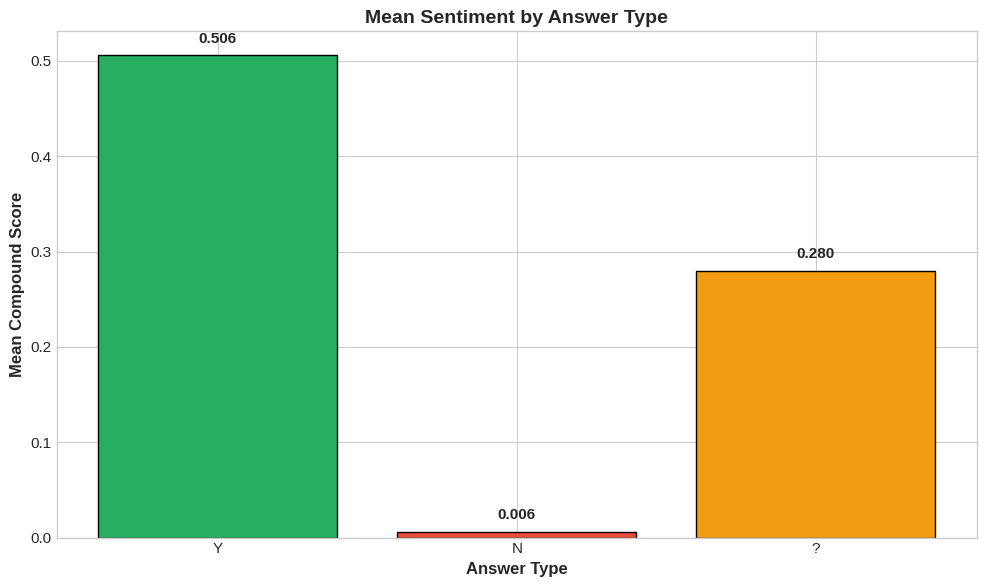

In [9]:
# Sentiment by Answer Type (for yes/no questions)
print("\nSENTIMENT BY ANSWER TYPE (Yes/No Questions)")
print("=" * 60)

if 'answerType' in df.columns:
    yes_no_df = df[df['questionType'] == 'yes/no'].copy()
    
    sentiment_by_answer = yes_no_df.groupby('answerType')['sentiment_compound'].agg(['mean', 'median', 'std', 'count'])
    print(sentiment_by_answer.round(3))
    
    # Visualize
    fig, ax = plt.subplots(figsize=(10, 6))
    answer_order = ['Y', 'N', '?']
    colors_answer = {'Y': '#27ae60', 'N': '#e74c3c', '?': '#f39c12'}
    
    means = yes_no_df.groupby('answerType')['sentiment_compound'].mean().reindex(answer_order)
    bars = ax.bar(means.index, means.values, 
                  color=[colors_answer.get(x, '#95a5a6') for x in means.index], 
                  edgecolor='black')
    ax.set_xlabel('Answer Type', fontsize=12, fontweight='bold')
    ax.set_ylabel('Mean Compound Score', fontsize=12, fontweight='bold')
    ax.set_title('Mean Sentiment by Answer Type', fontsize=14, fontweight='bold')
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    
    for bar, val in zip(bars, means.values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{val:.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('../visualizations/sentiment/sentiment_by_answer_type.png', dpi=150, bbox_inches='tight')
    plt.show()


---
## 3. Readability Scores

Calculate various readability metrics to assess answer complexity.


In [12]:
def calculate_readability(text):
    """Calculate various readability scores for text."""
    if pd.isna(text) or str(text).strip() == '':
        return {
            'flesch_reading_ease': np.nan,
            'flesch_kincaid_grade': np.nan,
            'gunning_fog': np.nan,
            'smog_index': np.nan,
            'automated_readability_index': np.nan,
            'coleman_liau_index': np.nan,
            'avg_sentence_length': np.nan,
            'avg_syllables_per_word': np.nan
        }
    
    text = str(text)
    
    try:
        return {
            'flesch_reading_ease': textstat.flesch_reading_ease(text),
            'flesch_kincaid_grade': textstat.flesch_kincaid_grade(text),
            'gunning_fog': textstat.gunning_fog(text),
            'smog_index': textstat.smog_index(text),
            'automated_readability_index': textstat.automated_readability_index(text),
            'coleman_liau_index': textstat.coleman_liau_index(text),
            'avg_sentence_length': textstat.avg_sentence_length(text),
            'avg_syllables_per_word': textstat.avg_syllables_per_word(text)
        }
    except:
        return {
            'flesch_reading_ease': np.nan,
            'flesch_kincaid_grade': np.nan,
            'gunning_fog': np.nan,
            'smog_index': np.nan,
            'automated_readability_index': np.nan,
            'coleman_liau_index': np.nan,
            'avg_sentence_length': np.nan,
            'avg_syllables_per_word': np.nan
        }

# Apply to answers
readability_scores = df['answer'].apply(calculate_readability)

# Extract individual scores
for metric in ['flesch_reading_ease', 'flesch_kincaid_grade', 'gunning_fog', 
               'smog_index', 'automated_readability_index', 'coleman_liau_index',
               'avg_sentence_length', 'avg_syllables_per_word']:
    df[metric] = readability_scores.apply(lambda x: x[metric])

In [13]:
# Readability Statistics
print("\nREADABILITY SCORES STATISTICS")
print("=" * 70)

readability_cols = ['flesch_reading_ease', 'flesch_kincaid_grade', 'gunning_fog', 
                    'smog_index', 'automated_readability_index', 'coleman_liau_index']

readability_stats = df[readability_cols].describe().round(2)
print(readability_stats)

print("\n\nReadability Score Interpretation (Flesch Reading Ease):")
print("-" * 50)
print("90-100: Very Easy (5th grade)")
print("80-89:  Easy (6th grade)")
print("70-79:  Fairly Easy (7th grade)")
print("60-69:  Standard (8th-9th grade)")
print("50-59:  Fairly Difficult (10th-12th grade)")
print("30-49:  Difficult (College)")
print("0-29:   Very Confusing (College Graduate)")



READABILITY SCORES STATISTICS
       flesch_reading_ease  flesch_kincaid_grade  gunning_fog  smog_index  \
count            184425.00             184425.00    184425.00   184425.00   
mean                 83.27                  4.34         6.51        6.67   
std                  41.10                  6.24         4.40        3.12   
min               -5716.18                 -8.91         0.00        3.13   
25%                  74.02                  2.14         3.28        3.13   
50%                  84.90                  4.15         6.22        7.17   
75%                  95.93                  6.37         8.66        8.84   
max                 162.50                810.80       137.12       71.92   

       automated_readability_index  coleman_liau_index  
count                    184425.00           184425.00  
mean                          4.10                2.56  
std                          13.13               14.78  
min                         -16.22             

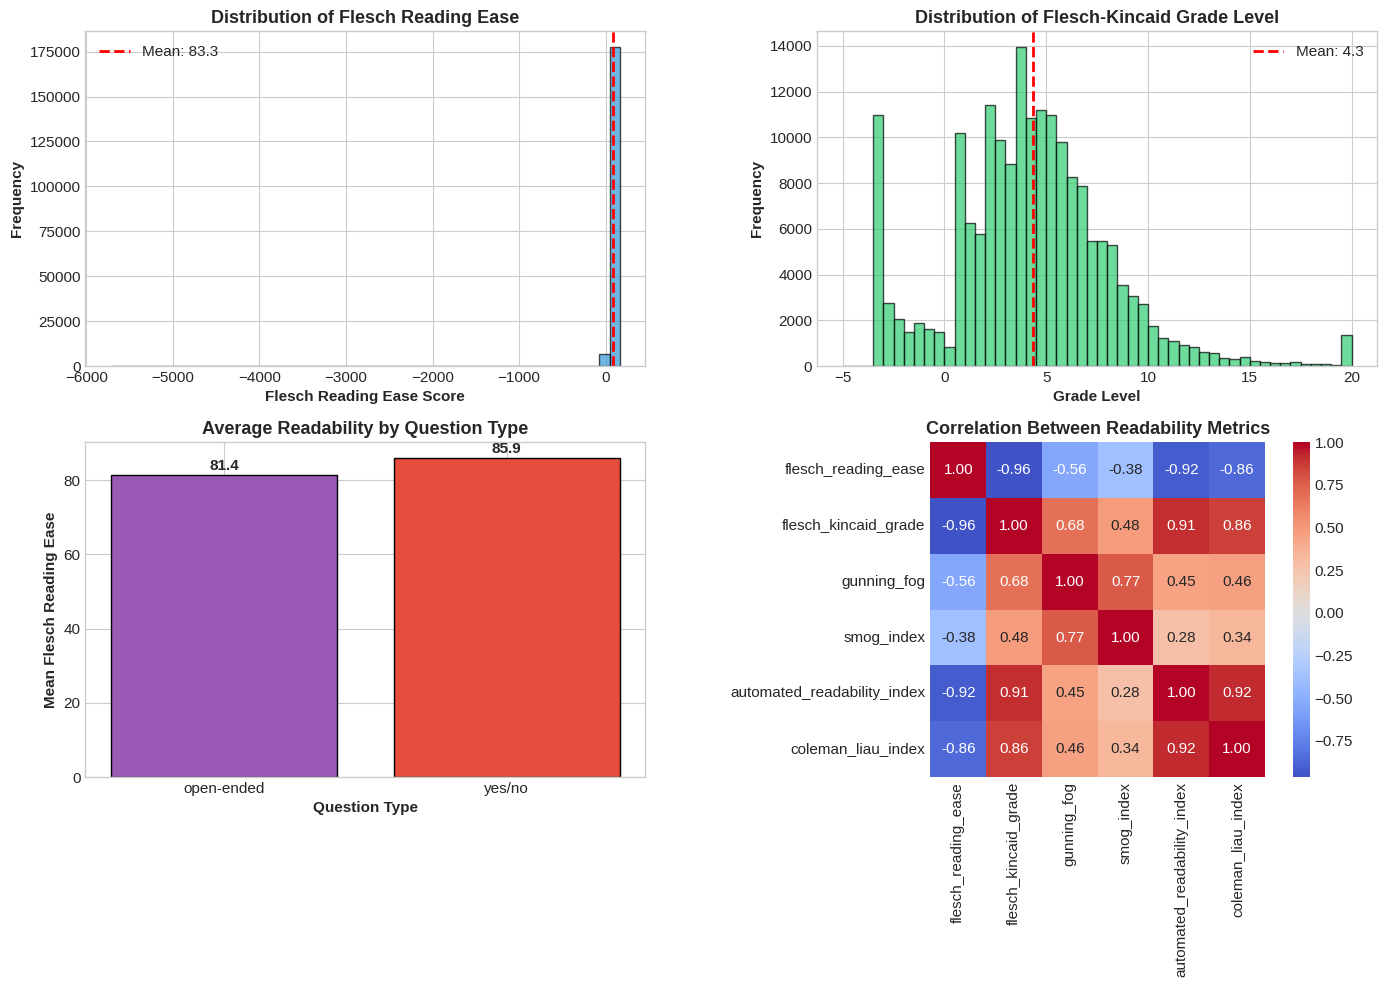

In [14]:
# Visualize Readability Scores
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Flesch Reading Ease Distribution
ax1 = axes[0, 0]
valid_fre = df['flesch_reading_ease'].dropna()
ax1.hist(valid_fre, bins=50, color='#3498db', edgecolor='black', alpha=0.7)
ax1.axvline(x=valid_fre.mean(), color='red', linestyle='--', linewidth=2, 
            label=f'Mean: {valid_fre.mean():.1f}')
ax1.set_xlabel('Flesch Reading Ease Score', fontsize=11, fontweight='bold')
ax1.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax1.set_title('Distribution of Flesch Reading Ease', fontsize=13, fontweight='bold')
ax1.legend()

# 2. Flesch-Kincaid Grade Level Distribution
ax2 = axes[0, 1]
valid_fkg = df['flesch_kincaid_grade'].dropna()
valid_fkg_clipped = valid_fkg.clip(-5, 20)  # Clip extreme values
ax2.hist(valid_fkg_clipped, bins=50, color='#2ecc71', edgecolor='black', alpha=0.7)
ax2.axvline(x=valid_fkg.mean(), color='red', linestyle='--', linewidth=2, 
            label=f'Mean: {valid_fkg.mean():.1f}')
ax2.set_xlabel('Grade Level', fontsize=11, fontweight='bold')
ax2.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax2.set_title('Distribution of Flesch-Kincaid Grade Level', fontsize=13, fontweight='bold')
ax2.legend()

# 3. Readability by Question Type
ax3 = axes[1, 0]
readability_by_type = df.groupby('questionType')['flesch_reading_ease'].mean()
bars = ax3.bar(readability_by_type.index, readability_by_type.values, 
               color=['#9b59b6', '#e74c3c'], edgecolor='black')
ax3.set_xlabel('Question Type', fontsize=11, fontweight='bold')
ax3.set_ylabel('Mean Flesch Reading Ease', fontsize=11, fontweight='bold')
ax3.set_title('Average Readability by Question Type', fontsize=13, fontweight='bold')
for bar, val in zip(bars, readability_by_type.values):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'{val:.1f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# 4. Correlation between readability metrics
ax4 = axes[1, 1]
corr_matrix = df[readability_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            fmt='.2f', ax=ax4, square=True)
ax4.set_title('Correlation Between Readability Metrics', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig('../visualizations/cf/readability_analysis.png', dpi=150, bbox_inches='tight')
plt.show()


---
## 4. Lexical Features (Punctuation Analysis)

*Note: Word count was already extracted in EDA. Here we focus on punctuation and other lexical features.*


In [16]:
# Extract Punctuation and Lexical Features
def extract_lexical_features(text):
    """Extract punctuation and other lexical features from text."""
    if pd.isna(text):
        text = ''
    text = str(text)
    
    return {
        'exclamation_count': text.count('!'),
        'question_mark_count': text.count('?'),
        'period_count': text.count('.'),
        'comma_count': text.count(','),
        'colon_count': text.count(':'),
        'semicolon_count': text.count(';'),
        'quote_count': text.count('"') + text.count("'"),
        'parenthesis_count': text.count('(') + text.count(')'),
        'total_punctuation': sum(1 for c in text if c in string.punctuation),
        'uppercase_count': sum(1 for c in text if c.isupper()),
        'digit_count': sum(1 for c in text if c.isdigit()),
        'sentence_count': len(re.split(r'[.!?]+', text.strip())) - 1 if text.strip() else 0,
        'avg_word_length': np.mean([len(w) for w in text.split()]) if text.split() else 0
    }

# Apply to answers
lexical_features = df['answer'].apply(extract_lexical_features)

# Extract individual features
for feature in ['exclamation_count', 'question_mark_count', 'period_count', 
                'comma_count', 'total_punctuation', 'uppercase_count', 
                'digit_count', 'sentence_count', 'avg_word_length']:
    df[feature] = lexical_features.apply(lambda x: x[feature])



In [17]:
# Lexical Features Statistics
print("\nLEXICAL FEATURES STATISTICS")
print("=" * 60)

lexical_cols = ['exclamation_count', 'question_mark_count', 'period_count', 
                'comma_count', 'total_punctuation', 'sentence_count', 'avg_word_length']

lexical_stats = df[lexical_cols].describe().round(2)
print(lexical_stats)



LEXICAL FEATURES STATISTICS
       exclamation_count  question_mark_count  period_count  comma_count  \
count          184439.00            184439.00     184439.00    184439.00   
mean                0.15                 0.03          2.49         0.92   
std                 0.58                 0.23          2.89         1.78   
min                 0.00                 0.00          0.00         0.00   
25%                 0.00                 0.00          1.00         0.00   
50%                 0.00                 0.00          2.00         0.00   
75%                 0.00                 0.00          3.00         1.00   
max                33.00                 9.00        209.00        95.00   

       total_punctuation  sentence_count  avg_word_length  
count          184439.00       184439.00        184439.00  
mean                5.36            2.42             4.27  
std                 7.10            2.47             2.71  
min                 0.00            0.00      

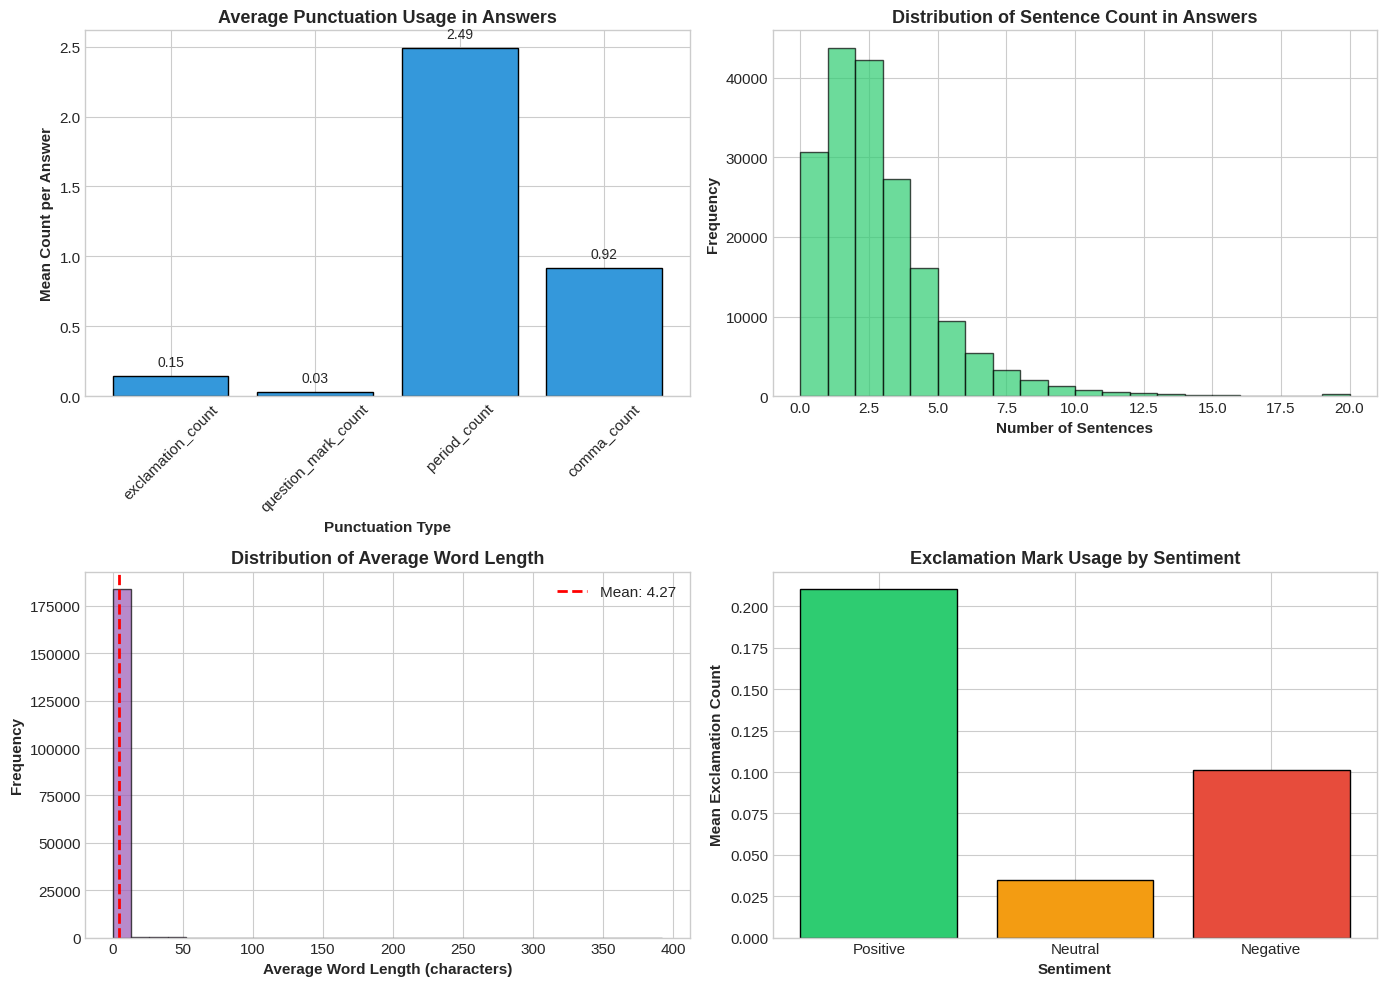

In [18]:
# Visualize Lexical Features
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Punctuation distribution
ax1 = axes[0, 0]
punct_means = df[['exclamation_count', 'question_mark_count', 'period_count', 'comma_count']].mean()
bars = ax1.bar(punct_means.index, punct_means.values, color='#3498db', edgecolor='black')
ax1.set_xlabel('Punctuation Type', fontsize=11, fontweight='bold')
ax1.set_ylabel('Mean Count per Answer', fontsize=11, fontweight='bold')
ax1.set_title('Average Punctuation Usage in Answers', fontsize=13, fontweight='bold')
ax1.tick_params(axis='x', rotation=45)
for bar, val in zip(bars, punct_means.values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, 
             f'{val:.2f}', ha='center', va='bottom', fontsize=10)

# 2. Sentence count distribution
ax2 = axes[0, 1]
ax2.hist(df['sentence_count'].clip(0, 20), bins=20, color='#2ecc71', edgecolor='black', alpha=0.7)
ax2.set_xlabel('Number of Sentences', fontsize=11, fontweight='bold')
ax2.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax2.set_title('Distribution of Sentence Count in Answers', fontsize=13, fontweight='bold')

# 3. Average word length distribution
ax3 = axes[1, 0]
ax3.hist(df['avg_word_length'].dropna(), bins=30, color='#9b59b6', edgecolor='black', alpha=0.7)
ax3.axvline(x=df['avg_word_length'].mean(), color='red', linestyle='--', linewidth=2,
            label=f'Mean: {df["avg_word_length"].mean():.2f}')
ax3.set_xlabel('Average Word Length (characters)', fontsize=11, fontweight='bold')
ax3.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax3.set_title('Distribution of Average Word Length', fontsize=13, fontweight='bold')
ax3.legend()

# 4. Exclamation marks by sentiment
ax4 = axes[1, 1]
exclaim_by_sentiment = df.groupby('sentiment_label')['exclamation_count'].mean()
order = ['Positive', 'Neutral', 'Negative']
exclaim_by_sentiment = exclaim_by_sentiment.reindex(order)
colors_sent = {'Positive': '#2ecc71', 'Neutral': '#f39c12', 'Negative': '#e74c3c'}
bars = ax4.bar(exclaim_by_sentiment.index, exclaim_by_sentiment.values,
               color=[colors_sent[x] for x in exclaim_by_sentiment.index], edgecolor='black')
ax4.set_xlabel('Sentiment', fontsize=11, fontweight='bold')
ax4.set_ylabel('Mean Exclamation Count', fontsize=11, fontweight='bold')
ax4.set_title('Exclamation Mark Usage by Sentiment', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig('../visualizations/cf/lexical_features.png', dpi=150, bbox_inches='tight')
plt.show()


---
## 5. User-Item Matrix Construction

**Approach:**
- Since the dataset doesn't have explicit user IDs, we create synthetic user identities
- **User**: Hash of answer text (proxy for unique answerer)
- **Item**: Product ASIN
- **Rating**: Normalized sentiment compound score (scaled 1-5)

This allows us to build a collaborative filtering model for product recommendations.


In [19]:
# Create User-Item Matrix
print("Building User-Item Matrix...")
print("=" * 60)

# Create user IDs based on answer text hash (proxy for unique answerer)
import hashlib

def create_user_id(text):
    """Create a user ID from answer text hash."""
    if pd.isna(text):
        return 'unknown'
    return hashlib.md5(str(text).encode()).hexdigest()[:8]

df['user_id'] = df['answer'].apply(create_user_id)

# Convert sentiment compound score to 1-5 rating scale
# Compound ranges from -1 to 1, we scale to 1-5
def sentiment_to_rating(compound):
    """Convert sentiment compound score (-1 to 1) to rating (1 to 5)."""
    # Scale from [-1, 1] to [1, 5]
    return ((compound + 1) / 2) * 4 + 1

df['rating'] = df['sentiment_compound'].apply(sentiment_to_rating)

print(f"Total unique users (answerers): {df['user_id'].nunique():,}")
print(f"Total unique items (products): {df['asin'].nunique():,}")
print(f"Total interactions: {len(df):,}")
print(f"\nRating Statistics:")
print(df['rating'].describe().round(2))


Building User-Item Matrix...
Total unique users (answerers): 159,477
Total unique items (products): 24,501
Total interactions: 184,439

Rating Statistics:
count    184439.00
mean          3.58
std           0.83
min           1.01
25%           3.00
50%           3.62
75%           4.31
max           5.00
Name: rating, dtype: float64


In [20]:
# Create aggregated user-item interactions
print("\nCreating aggregated user-item interactions...")

user_item_df = df.groupby(['user_id', 'asin']).agg({
    'rating': 'mean',
    'sentiment_compound': 'mean',
    'answer': 'count'
}).reset_index()
user_item_df.columns = ['user_id', 'asin', 'rating', 'sentiment', 'interaction_count']

print(f"Unique user-item pairs: {len(user_item_df):,}")
print(f"\nInteraction count distribution:")
print(user_item_df['interaction_count'].value_counts().head(10))



Creating aggregated user-item interactions...
Unique user-item pairs: 183,785

Interaction count distribution:
interaction_count
1    183185
2       550
3        46
4         4
Name: count, dtype: int64


In [21]:
# Filter to users and items with sufficient interactions for meaningful CF
MIN_USER_INTERACTIONS = 2
MIN_ITEM_INTERACTIONS = 5

print(f"\nFiltering for CF (min {MIN_USER_INTERACTIONS} user interactions, min {MIN_ITEM_INTERACTIONS} item interactions)...")

# Count interactions per user and item
user_counts = user_item_df.groupby('user_id').size()
item_counts = user_item_df.groupby('asin').size()

# Filter users and items
valid_users = user_counts[user_counts >= MIN_USER_INTERACTIONS].index
valid_items = item_counts[item_counts >= MIN_ITEM_INTERACTIONS].index

# Filter dataframe
cf_df = user_item_df[
    (user_item_df['user_id'].isin(valid_users)) & 
    (user_item_df['asin'].isin(valid_items))
].copy()

print(f"After filtering:")
print(f"  Users: {cf_df['user_id'].nunique():,}")
print(f"  Items: {cf_df['asin'].nunique():,}")
print(f"  Interactions: {len(cf_df):,}")
print(f"  Sparsity: {1 - len(cf_df) / (cf_df['user_id'].nunique() * cf_df['asin'].nunique()):.4%}")



Filtering for CF (min 2 user interactions, min 5 item interactions)...
After filtering:
  Users: 5,686
  Items: 10,204
  Interactions: 28,219
  Sparsity: 99.9514%


In [22]:
# Create mappings for users and items
user_to_idx = {user: idx for idx, user in enumerate(cf_df['user_id'].unique())}
idx_to_user = {idx: user for user, idx in user_to_idx.items()}

item_to_idx = {item: idx for idx, item in enumerate(cf_df['asin'].unique())}
idx_to_item = {idx: item for item, idx in item_to_idx.items()}

n_users = len(user_to_idx)
n_items = len(item_to_idx)

print(f"User-Item Matrix Dimensions: {n_users} x {n_items}")

# Create sparse user-item matrix
row_indices = cf_df['user_id'].map(user_to_idx).values
col_indices = cf_df['asin'].map(item_to_idx).values
ratings = cf_df['rating'].values

user_item_matrix = csr_matrix((ratings, (row_indices, col_indices)), shape=(n_users, n_items))

print(f"Matrix created with {user_item_matrix.nnz} non-zero entries")
print(f"Matrix density: {user_item_matrix.nnz / (n_users * n_items):.6%}")


User-Item Matrix Dimensions: 5686 x 10204
Matrix created with 28219 non-zero entries
Matrix density: 0.048637%


---
## 6. Collaborative Filtering Implementation

### 6.1 Item-Item Collaborative Filtering


In [23]:
# Train-Test Split
print("Splitting data into train and test sets...")

# Split the CF dataframe
train_df, test_df = train_test_split(cf_df, test_size=0.2, random_state=42)

print(f"Training set: {len(train_df):,} interactions")
print(f"Test set: {len(test_df):,} interactions")

# Create training matrix
train_row = train_df['user_id'].map(user_to_idx).values
train_col = train_df['asin'].map(item_to_idx).values
train_ratings = train_df['rating'].values

train_matrix = csr_matrix((train_ratings, (train_row, train_col)), shape=(n_users, n_items))
train_matrix_dense = train_matrix.toarray()

print(f"\nTraining matrix: {train_matrix.shape}")
print(f"Non-zero entries: {train_matrix.nnz}")


Splitting data into train and test sets...
Training set: 22,575 interactions
Test set: 5,644 interactions

Training matrix: (5686, 10204)
Non-zero entries: 22575


In [ ]:
# Item-Item Collaborative Filtering
print("\n" + "=" * 60)
print("ITEM-ITEM COLLABORATIVE FILTERING")
print("=" * 60)

class ItemItemCF:
    """Item-Item Collaborative Filtering using cosine similarity."""
    
    def __init__(self, k=20):
        self.k = k 
        self.item_similarity = None
        self.train_matrix = None
        self.global_mean = None
        
    def fit(self, train_matrix):
        """Fit the model by computing item-item similarity."""
        self.train_matrix = train_matrix
        self.global_mean = train_matrix[train_matrix > 0].mean()
        
        # Compute item-item cosine similarity
        # Transpose to get items as rows
        item_matrix = train_matrix.T
        
        # Normalize by number of non-zero entries for each item
        item_norms = np.sqrt((item_matrix.power(2)).sum(axis=1))
        item_norms = np.array(item_norms).flatten()
        item_norms[item_norms == 0] = 1  # Avoid division by zero
        
        # Compute cosine similarity
        self.item_similarity = cosine_similarity(item_matrix)
        np.fill_diagonal(self.item_similarity, 0)  # Remove self-similarity
        
        print(f"Item similarity matrix computed: {self.item_similarity.shape}")
        
    def predict(self, user_idx, item_idx):
        """Predict rating for a user-item pair."""
        user_ratings = self.train_matrix[user_idx].toarray().flatten()
        item_sims = self.item_similarity[item_idx]
        
        # Get items rated by this user
        rated_items = np.where(user_ratings > 0)[0]
        
        if len(rated_items) == 0:
            return self.global_mean
        
        # Get top-k similar items that the user has rated
        similar_items = []
        for rated_item in rated_items:
            similar_items.append((rated_item, item_sims[rated_item]))
        
        similar_items.sort(key=lambda x: x[1], reverse=True)
        top_k = similar_items[:self.k]
        
        # Weighted average of ratings
        numerator = sum(sim * user_ratings[item] for item, sim in top_k if sim > 0)
        denominator = sum(abs(sim) for _, sim in top_k if sim > 0)
        
        if denominator == 0:
            return self.global_mean
        
        return numerator / denominator
    
    def predict_batch(self, test_df, user_to_idx, item_to_idx):
        """Predict ratings for a batch of user-item pairs."""
        predictions = []
        
        for _, row in test_df.iterrows():
            user_idx = user_to_idx.get(row['user_id'])
            item_idx = item_to_idx.get(row['asin'])
            
            if user_idx is None or item_idx is None:
                predictions.append(self.global_mean)
            else:
                predictions.append(self.predict(user_idx, item_idx))
        
        return np.array(predictions)

# Train Item-Item CF
item_cf = ItemItemCF(k=20)
item_cf.fit(train_matrix)

print("Item-Item CF model trained!")



ITEM-ITEM COLLABORATIVE FILTERING
Item similarity matrix computed: (10204, 10204)
Item-Item CF model trained!


### 6.2 User-User Collaborative Filtering


In [25]:
# User-User Collaborative Filtering
print("\n" + "=" * 60)
print("USER-USER COLLABORATIVE FILTERING")
print("=" * 60)

class UserUserCF:
    """User-User Collaborative Filtering using cosine similarity."""
    
    def __init__(self, k=20):
        self.k = k  # Number of similar users to consider
        self.user_similarity = None
        self.train_matrix = None
        self.global_mean = None
        self.user_means = None
        
    def fit(self, train_matrix):
        """Fit the model by computing user-user similarity."""
        self.train_matrix = train_matrix
        self.global_mean = train_matrix[train_matrix > 0].mean()
        
        # Calculate user means (for mean-centering)
        user_sums = np.array(train_matrix.sum(axis=1)).flatten()
        user_counts = np.array((train_matrix > 0).sum(axis=1)).flatten()
        user_counts[user_counts == 0] = 1  # Avoid division by zero
        self.user_means = user_sums / user_counts
        
        # Compute user-user cosine similarity
        self.user_similarity = cosine_similarity(train_matrix)
        np.fill_diagonal(self.user_similarity, 0)  # Remove self-similarity
        
        print(f"User similarity matrix computed: {self.user_similarity.shape}")
        
    def predict(self, user_idx, item_idx):
        """Predict rating for a user-item pair."""
        item_ratings = self.train_matrix[:, item_idx].toarray().flatten()
        user_sims = self.user_similarity[user_idx]
        
        # Get users who rated this item
        rated_users = np.where(item_ratings > 0)[0]
        
        if len(rated_users) == 0:
            return self.user_means[user_idx] if self.user_means[user_idx] > 0 else self.global_mean
        
        # Get top-k similar users who rated this item
        similar_users = []
        for rated_user in rated_users:
            similar_users.append((rated_user, user_sims[rated_user]))
        
        similar_users.sort(key=lambda x: x[1], reverse=True)
        top_k = similar_users[:self.k]
        
        # Weighted average of ratings (mean-centered)
        numerator = sum(sim * (item_ratings[user] - self.user_means[user]) 
                        for user, sim in top_k if sim > 0)
        denominator = sum(abs(sim) for _, sim in top_k if sim > 0)
        
        if denominator == 0:
            return self.user_means[user_idx] if self.user_means[user_idx] > 0 else self.global_mean
        
        prediction = self.user_means[user_idx] + (numerator / denominator)
        
        # Clip to valid rating range
        return np.clip(prediction, 1, 5)
    
    def predict_batch(self, test_df, user_to_idx, item_to_idx):
        """Predict ratings for a batch of user-item pairs."""
        predictions = []
        
        for _, row in test_df.iterrows():
            user_idx = user_to_idx.get(row['user_id'])
            item_idx = item_to_idx.get(row['asin'])
            
            if user_idx is None or item_idx is None:
                predictions.append(self.global_mean)
            else:
                predictions.append(self.predict(user_idx, item_idx))
        
        return np.array(predictions)

# Train User-User CF
user_cf = UserUserCF(k=20)
user_cf.fit(train_matrix)

print("User-User CF model trained!")



USER-USER COLLABORATIVE FILTERING
User similarity matrix computed: (5686, 5686)
User-User CF model trained!


---
## 7. Model Evaluation (RMSE/MAE)


In [27]:
# Generate predictions for test set
print("Generating predictions for test set...")

# Sample test set if too large (for faster evaluation)
if len(test_df) > 5000:
    test_sample = test_df.sample(n=5000, random_state=42)
    print(f"Using sample of {len(test_sample)} test instances for evaluation")
else:
    test_sample = test_df

# Get actual ratings
actual_ratings = test_sample['rating'].values

# Baseline: Global Mean
baseline_predictions = np.full(len(test_sample), item_cf.global_mean)

# Item-Item CF predictions
print("\nGenerating Item-Item CF predictions...")
item_cf_predictions = item_cf.predict_batch(test_sample, user_to_idx, item_to_idx)

# User-User CF predictions
print("Generating User-User CF predictions...")
user_cf_predictions = user_cf.predict_batch(test_sample, user_to_idx, item_to_idx)

Generating predictions for test set...
Using sample of 5000 test instances for evaluation

Generating Item-Item CF predictions...
Generating User-User CF predictions...


In [28]:
# Calculate evaluation metrics
def evaluate_predictions(actual, predicted, model_name):
    """Calculate RMSE and MAE for predictions."""
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mae = mean_absolute_error(actual, predicted)
    return {'Model': model_name, 'RMSE': rmse, 'MAE': mae}

# Evaluate all models
results = []
results.append(evaluate_predictions(actual_ratings, baseline_predictions, 'Baseline (Global Mean)'))
results.append(evaluate_predictions(actual_ratings, item_cf_predictions, 'Item-Item CF'))
results.append(evaluate_predictions(actual_ratings, user_cf_predictions, 'User-User CF'))

# Create results dataframe
results_df = pd.DataFrame(results)

print("\n" + "=" * 60)
print("MODEL EVALUATION RESULTS")
print("=" * 60)
print(f"\nTest Set Size: {len(test_sample):,}")
print(f"Rating Scale: 1-5 (derived from sentiment)")
print("\n")
print(results_df.to_string(index=False))
print("\n" + "=" * 60)



MODEL EVALUATION RESULTS

Test Set Size: 5,000
Rating Scale: 1-5 (derived from sentiment)


                 Model     RMSE      MAE
Baseline (Global Mean) 0.770970 0.662433
          Item-Item CF 0.382875 0.200110
          User-User CF 0.177635 0.032028



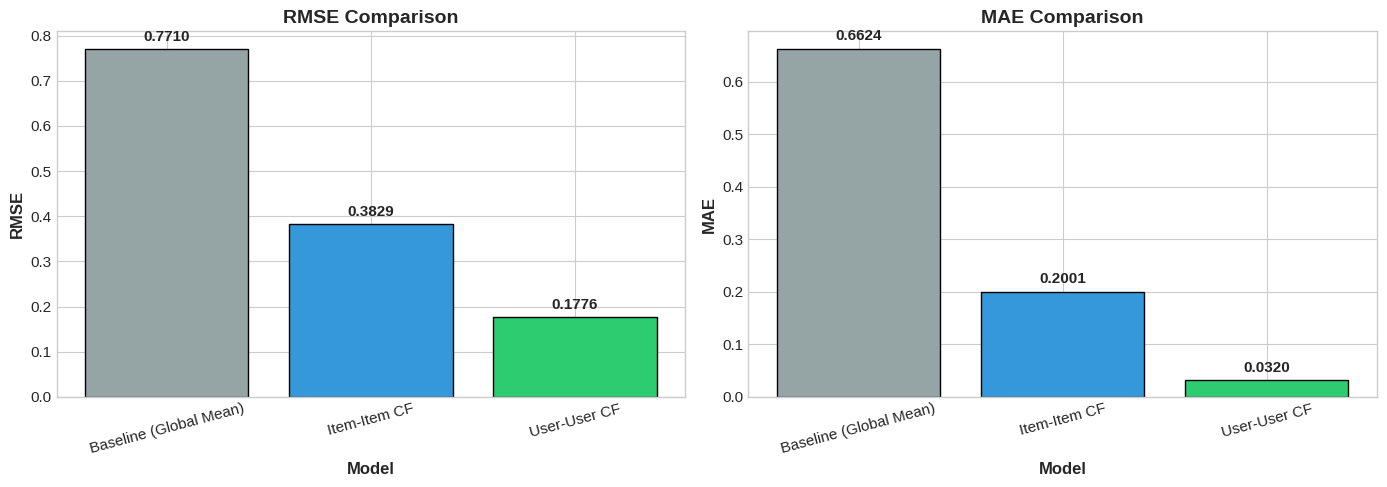

In [29]:
# Visualize Results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. RMSE Comparison
ax1 = axes[0]
colors = ['#95a5a6', '#3498db', '#2ecc71']
bars1 = ax1.bar(results_df['Model'], results_df['RMSE'], color=colors, edgecolor='black')
ax1.set_xlabel('Model', fontsize=12, fontweight='bold')
ax1.set_ylabel('RMSE', fontsize=12, fontweight='bold')
ax1.set_title('RMSE Comparison', fontsize=14, fontweight='bold')
ax1.tick_params(axis='x', rotation=15)

for bar, val in zip(bars1, results_df['RMSE']):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{val:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# 2. MAE Comparison
ax2 = axes[1]
bars2 = ax2.bar(results_df['Model'], results_df['MAE'], color=colors, edgecolor='black')
ax2.set_xlabel('Model', fontsize=12, fontweight='bold')
ax2.set_ylabel('MAE', fontsize=12, fontweight='bold')
ax2.set_title('MAE Comparison', fontsize=14, fontweight='bold')
ax2.tick_params(axis='x', rotation=15)

for bar, val in zip(bars2, results_df['MAE']):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{val:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('../visualizations/cf/cf_evaluation.png', dpi=150, bbox_inches='tight')
plt.show()


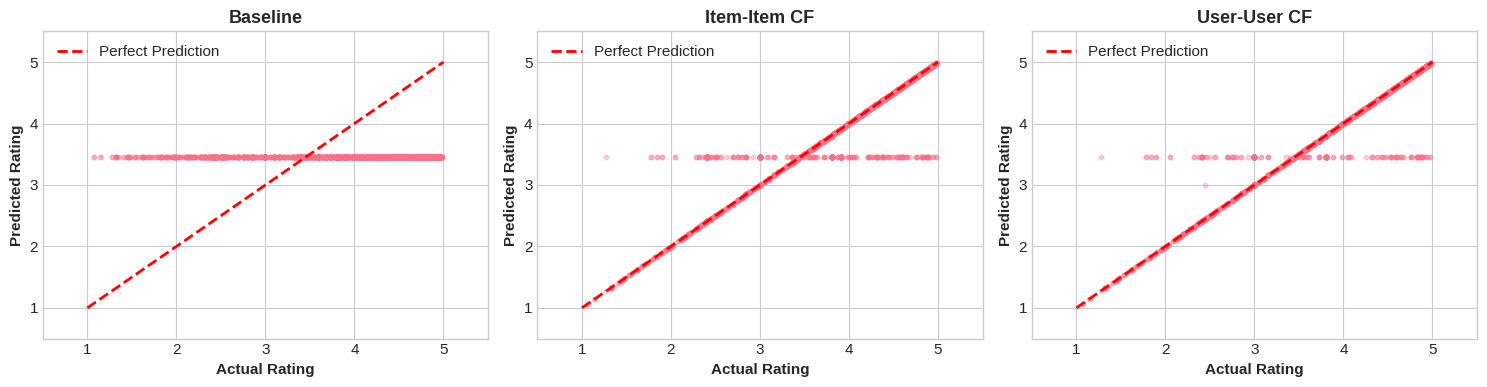

In [30]:
# Prediction vs Actual scatter plots
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

models = [
    ('Baseline', baseline_predictions),
    ('Item-Item CF', item_cf_predictions),
    ('User-User CF', user_cf_predictions)
]

for ax, (name, preds) in zip(axes, models):
    ax.scatter(actual_ratings, preds, alpha=0.3, s=10)
    ax.plot([1, 5], [1, 5], 'r--', linewidth=2, label='Perfect Prediction')
    ax.set_xlabel('Actual Rating', fontsize=11, fontweight='bold')
    ax.set_ylabel('Predicted Rating', fontsize=11, fontweight='bold')
    ax.set_title(f'{name}', fontsize=13, fontweight='bold')
    ax.set_xlim(0.5, 5.5)
    ax.set_ylim(0.5, 5.5)
    ax.legend()

plt.tight_layout()
plt.savefig('../visualizations/cf/prediction_scatter.png', dpi=150, bbox_inches='tight')
plt.show()


In [31]:
# Detailed error analysis
print("\nDETAILED ERROR ANALYSIS")
print("=" * 60)

for name, preds in models:
    errors = actual_ratings - preds
    print(f"\n{name}:")
    print(f"  Mean Error: {errors.mean():.4f}")
    print(f"  Std Error:  {errors.std():.4f}")
    print(f"  Min Error:  {errors.min():.4f}")
    print(f"  Max Error:  {errors.max():.4f}")



DETAILED ERROR ANALYSIS

Baseline:
  Mean Error: -0.0073
  Std Error:  0.7709
  Min Error:  -2.3920
  Max Error:  1.5272

Item-Item CF:
  Mean Error: -0.0696
  Std Error:  0.3765
  Min Error:  -2.1864
  Max Error:  1.5136

User-User CF:
  Mean Error: 0.0014
  Std Error:  0.1776
  Min Error:  -2.1864
  Max Error:  1.5136


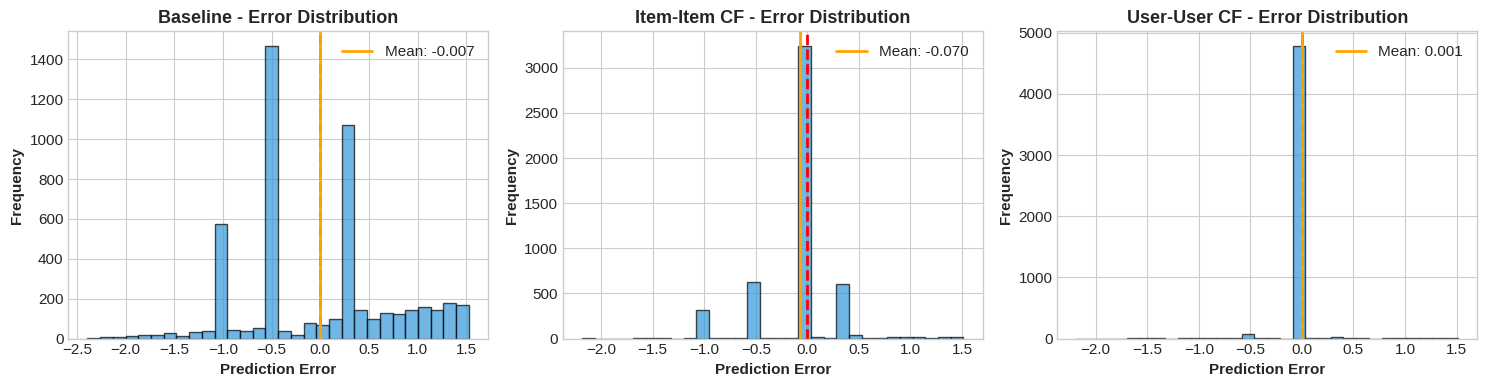

In [32]:
# Error distribution visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, (name, preds) in zip(axes, models):
    errors = actual_ratings - preds
    ax.hist(errors, bins=30, color='#3498db', edgecolor='black', alpha=0.7)
    ax.axvline(x=0, color='red', linestyle='--', linewidth=2)
    ax.axvline(x=errors.mean(), color='orange', linestyle='-', linewidth=2, 
               label=f'Mean: {errors.mean():.3f}')
    ax.set_xlabel('Prediction Error', fontsize=11, fontweight='bold')
    ax.set_ylabel('Frequency', fontsize=11, fontweight='bold')
    ax.set_title(f'{name} - Error Distribution', fontsize=13, fontweight='bold')
    ax.legend()

plt.tight_layout()
plt.savefig('../visualizations/cf/error_distribution.png', dpi=150, bbox_inches='tight')
plt.show()


---
## 8. Summary and Save Results


In [33]:
# Final Summary
print("\n" + "=" * 70)
print("              ANALYSIS SUMMARY")
print("=" * 70)

print(f"""
📊 SENTIMENT ANALYSIS
─────────────────────────────────────────────────────────────────────
Total Answers Analyzed:    {len(df):,}
Positive Sentiment:        {(df['sentiment_label'] == 'Positive').sum():,} ({(df['sentiment_label'] == 'Positive').sum()/len(df)*100:.1f}%)
Neutral Sentiment:         {(df['sentiment_label'] == 'Neutral').sum():,} ({(df['sentiment_label'] == 'Neutral').sum()/len(df)*100:.1f}%)
Negative Sentiment:        {(df['sentiment_label'] == 'Negative').sum():,} ({(df['sentiment_label'] == 'Negative').sum()/len(df)*100:.1f}%)
Mean Compound Score:       {df['sentiment_compound'].mean():.4f}

📖 READABILITY SCORES
─────────────────────────────────────────────────────────────────────
Mean Flesch Reading Ease:  {df['flesch_reading_ease'].mean():.2f}
Mean Grade Level:          {df['flesch_kincaid_grade'].mean():.2f}

📝 LEXICAL FEATURES
─────────────────────────────────────────────────────────────────────
Avg Sentences/Answer:      {df['sentence_count'].mean():.2f}
Avg Word Length:           {df['avg_word_length'].mean():.2f} chars
Avg Punctuation/Answer:    {df['total_punctuation'].mean():.2f}

🤝 COLLABORATIVE FILTERING
─────────────────────────────────────────────────────────────────────
Users (Answerers):         {n_users:,}
Items (Products):          {n_items:,}
Training Interactions:     {len(train_df):,}
Test Interactions:         {len(test_sample):,}

📈 MODEL PERFORMANCE (Lower is Better)
─────────────────────────────────────────────────────────────────────
""")

print(results_df.to_string(index=False))




              ANALYSIS SUMMARY

📊 SENTIMENT ANALYSIS
─────────────────────────────────────────────────────────────────────
Total Answers Analyzed:    184,439
Positive Sentiment:        107,283 (58.2%)
Neutral Sentiment:         51,119 (27.7%)
Negative Sentiment:        26,037 (14.1%)
Mean Compound Score:       0.2900

📖 READABILITY SCORES
─────────────────────────────────────────────────────────────────────
Mean Flesch Reading Ease:  83.27
Mean Grade Level:          4.34

📝 LEXICAL FEATURES
─────────────────────────────────────────────────────────────────────
Avg Sentences/Answer:      2.42
Avg Word Length:           4.27 chars
Avg Punctuation/Answer:    5.36

🤝 COLLABORATIVE FILTERING
─────────────────────────────────────────────────────────────────────
Users (Answerers):         5,686
Items (Products):          10,204
Training Interactions:     22,575
Test Interactions:         5,000

📈 MODEL PERFORMANCE (Lower is Better)
─────────────────────────────────────────────────────────────

In [34]:
# Save enhanced dataframe with all new features
output_path = '../data/processed/enhanced_home_kitchen_qa.pkl'
df.to_pickle(output_path)

print(f"Enhanced dataframe saved to '{output_path}'")
print(f"\nNew columns added:")
new_cols = ['sentiment_neg', 'sentiment_neu', 'sentiment_pos', 'sentiment_compound', 
            'sentiment_label', 'flesch_reading_ease', 'flesch_kincaid_grade', 
            'gunning_fog', 'smog_index', 'exclamation_count', 'question_mark_count',
            'sentence_count', 'avg_word_length', 'user_id', 'rating']
for col in new_cols:
    if col in df.columns:
        print(f"  - {col}")

# Save evaluation results
results_df.to_csv('../results/cf_evaluation_results.csv', index=False)



Enhanced dataframe saved to '../data/processed/enhanced_home_kitchen_qa.pkl'

New columns added:
  - sentiment_neg
  - sentiment_neu
  - sentiment_pos
  - sentiment_compound
  - sentiment_label
  - flesch_reading_ease
  - flesch_kincaid_grade
  - gunning_fog
  - smog_index
  - exclamation_count
  - question_mark_count
  - sentence_count
  - avg_word_length
  - user_id
  - rating
